
# 1. Introduction

In this study we'll try to predict the **Weight** of a fish using the informations contained in the **Fish Market Dataset**, downloadable on [Kaggle](https://www.kaggle.com/aungpyaeap/fish-market).
In the first part, we're going to focus on understanding the data and all of his variables, using statistical analysis and visualization techniques. After that, we're going to use **Multiple Linear Regression** and a series of tests and plots to build different models, and decide which is the optimal choice to complete our task.

## This is the "R Version" of this Notebook, but if you're more familiar with Python, you can check out the "Python Version" [here](https://www.kaggle.com/gaetanochiriaco/weight-prediction-loglog-regression-py-version)



# 2. Libraries

In [1]:
library(ggplot2)
library(GGally)
library(dplyr)
library(caTools)
library(lmtest)
library(caret)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘dplyr’


The following object is masked from ‘package:GGally’:

    nasa


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress





These are the libraries we need:

- **ggplot2**: For various visualization functions. Most of the plots that are shown in this notebook can be obtained also with the R base package, but I raccomend using **ggplot** for its simplicity and power;
- **GGally**: For the function *ggpairs()*. This library is totally optional. Very similar results can be obtained by using the basic *plot()* function on our dataset;
- **Dplyr**: For data cleaning and manipulation. Very useful functions are contined in this library, like *select()*,*filter()* and *groupby()*;
- **caTools** and **Caret**: For the functions *sample.split()* and *R2()*. These libraries have useful functions for splitting our data in test and train set, and to verify the proprieties and the predictive power of our models;
- **Lmtest**: For Hypotesis testing. We're going to use this library for the function *bptest()*, that allows us to perform a **Breusch & Pagan Test**. This test is used to check if the residuals of our linear model are **Heteroskedastical** or **Homoskedastical**.If you don't know what i'm talking about, I raccomend reading more about heteroskedasticity and B&P Test at this [link](https://rstudio-pubs-static.s3.amazonaws.com/187387_3ca34c107405427db0e0f01252b3fbdb.html).

# 3. Importing Data and first Analysis

Let's start by importing the dataset.

In [2]:
fish <- read.csv("../input/fish-market/Fish.csv")


We can take a first look at the our data using the *str()* function.


In [3]:
str(fish)

'data.frame':	159 obs. of  7 variables:
 $ Species: Factor w/ 7 levels "Bream","Parkki",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Weight : num  242 290 340 363 430 450 500 390 450 500 ...
 $ Length1: num  23.2 24 23.9 26.3 26.5 26.8 26.8 27.6 27.6 28.5 ...
 $ Length2: num  25.4 26.3 26.5 29 29 29.7 29.7 30 30 30.7 ...
 $ Length3: num  30 31.2 31.1 33.5 34 34.7 34.5 35 35.1 36.2 ...
 $ Height : num  11.5 12.5 12.4 12.7 12.4 ...
 $ Width  : num  4.02 4.31 4.7 4.46 5.13 ...


As you can see, all the variables are well specified.
**Species** is the only Factor variable, while the other six are continuous.
Later, **Weight** is going to be our dependent variable, and we are going to predict it's value using the other features as **indipendent variables**.

For a better understanding of the meaning of the variables, it's preferable to change their names.

In [4]:
names(fish) <- c("Species","Weight","LengthV","LengthD","LengthC","Height","Width")

Let's use the *summary()* to see how our dataset is structured and check if there are any obvious **outliers** or **missing values**

In [5]:
summary(fish)

cat("Are there any missing value in the dataset?" ,any(is.na(fish)))

      Species       Weight          LengthV         LengthD     
 Bream    :35   Min.   :   0.0   Min.   : 7.50   Min.   : 8.40  
 Parkki   :11   1st Qu.: 120.0   1st Qu.:19.05   1st Qu.:21.00  
 Perch    :56   Median : 273.0   Median :25.20   Median :27.30  
 Pike     :17   Mean   : 398.3   Mean   :26.25   Mean   :28.42  
 Roach    :20   3rd Qu.: 650.0   3rd Qu.:32.70   3rd Qu.:35.50  
 Smelt    :14   Max.   :1650.0   Max.   :59.00   Max.   :63.40  
 Whitefish: 6                                                   
    LengthC          Height           Width      
 Min.   : 8.80   Min.   : 1.728   Min.   :1.048  
 1st Qu.:23.15   1st Qu.: 5.945   1st Qu.:3.386  
 Median :29.40   Median : 7.786   Median :4.248  
 Mean   :31.23   Mean   : 8.971   Mean   :4.417  
 3rd Qu.:39.65   3rd Qu.:12.366   3rd Qu.:5.585  
 Max.   :68.00   Max.   :18.957   Max.   :8.142  
                                                 

Are there any missing value in the dataset? FALSE

The dataset doesn't have any missing value, and there are no negative values. Our data is already fairly clean!

There's only one observation that we need to fix:


In [6]:
fish[41,]

,Species,Weight,LengthV,LengthD,LengthC,Height,Width
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Roach,0,19,20.5,22.8,6.4752,3.3516


The fish at row 41 weights **0 g**. So, to avoid errors when using the logarithmic transformation, it's better to drop this observation.

In [7]:
fish <- fish%>%
  filter(Weight>0)

# 4. Analysis and Visulization

Using the *summary()* and *str()* functions we collected a lot of interesting informations. But that's not enough!.
Before diving in the modelling and prediction phase, we need to deeply understand our data, through some really simple visualization and data analysis techniques.

Let's take a look at the distribution of our dependent variable, **Weight**, using an **histogram**

In [8]:
options(repr.plot.width = 14, repr.plot.height = 8)

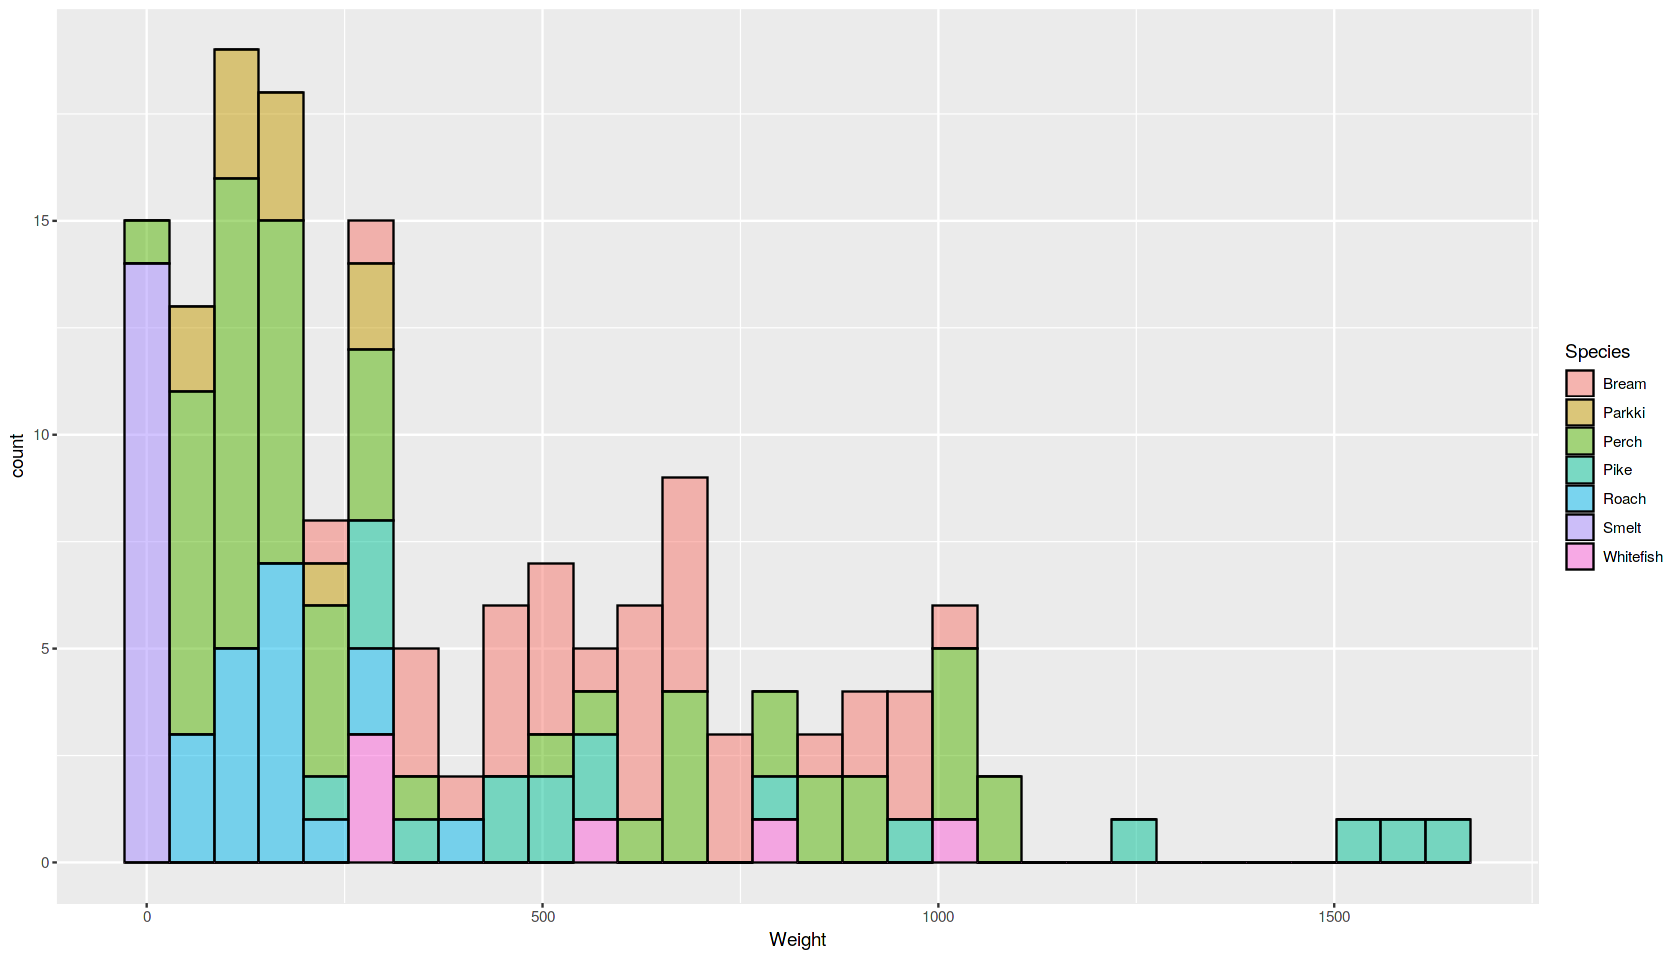

In [9]:
ggplot(fish,aes(x=Weight,fill=Species))+
  geom_histogram(alpha=0.5,col="black",bins=30)

We can also use the following script to study the distribution of **Weight**, grouped by **Species**, with a density plot. The vertical dashed lines show us the **mean Weight** for each **Species**.
In the dataset *fish.means*, we can easily see how the mean **Weight** differs between the different **Species** of fishes

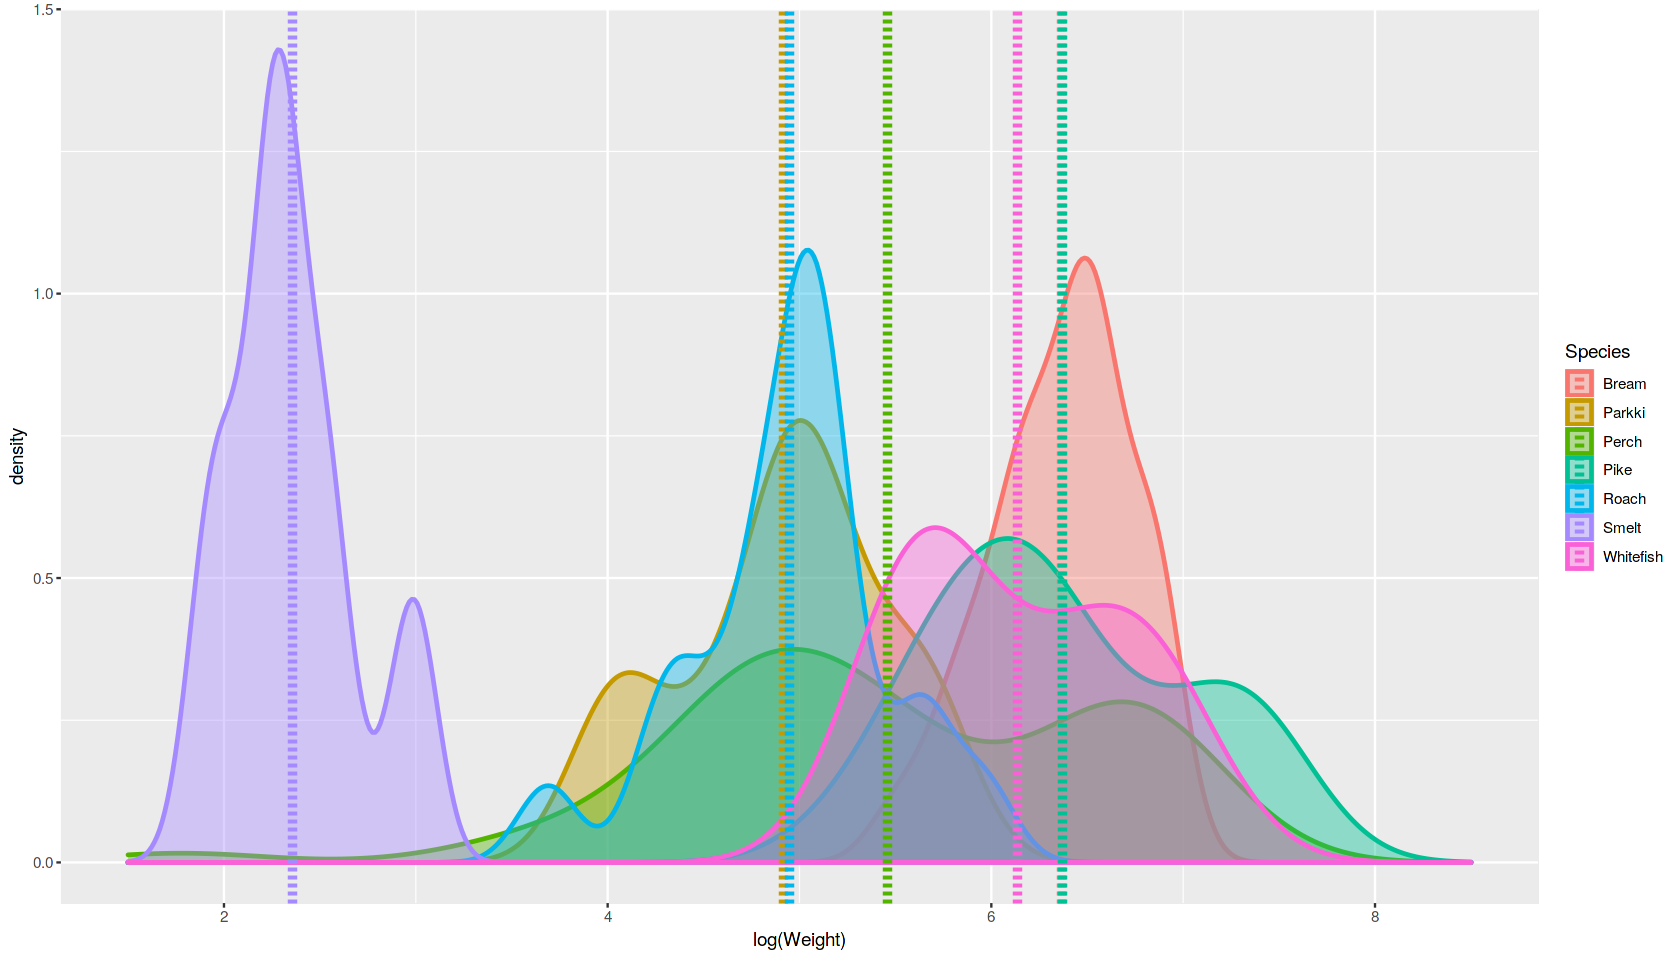

In [10]:
fish.means <- fish %>%
              group_by(Species)%>%
              summarise(Mean_weight=mean(log(Weight)))


ggplot(fish,aes(x=log(Weight),fill=Species,color=Species,group=Species))+
  geom_density(alpha=0.4,lwd=1)+
  geom_vline(data=fish.means,aes(xintercept = Mean_weight,color=Species),lwd=2,lty="dashed")+
  scale_x_continuous(limits = c(1.5,8.5))

To rapidly visualize all of our continuous data, We can use the function *ggpairs()*.

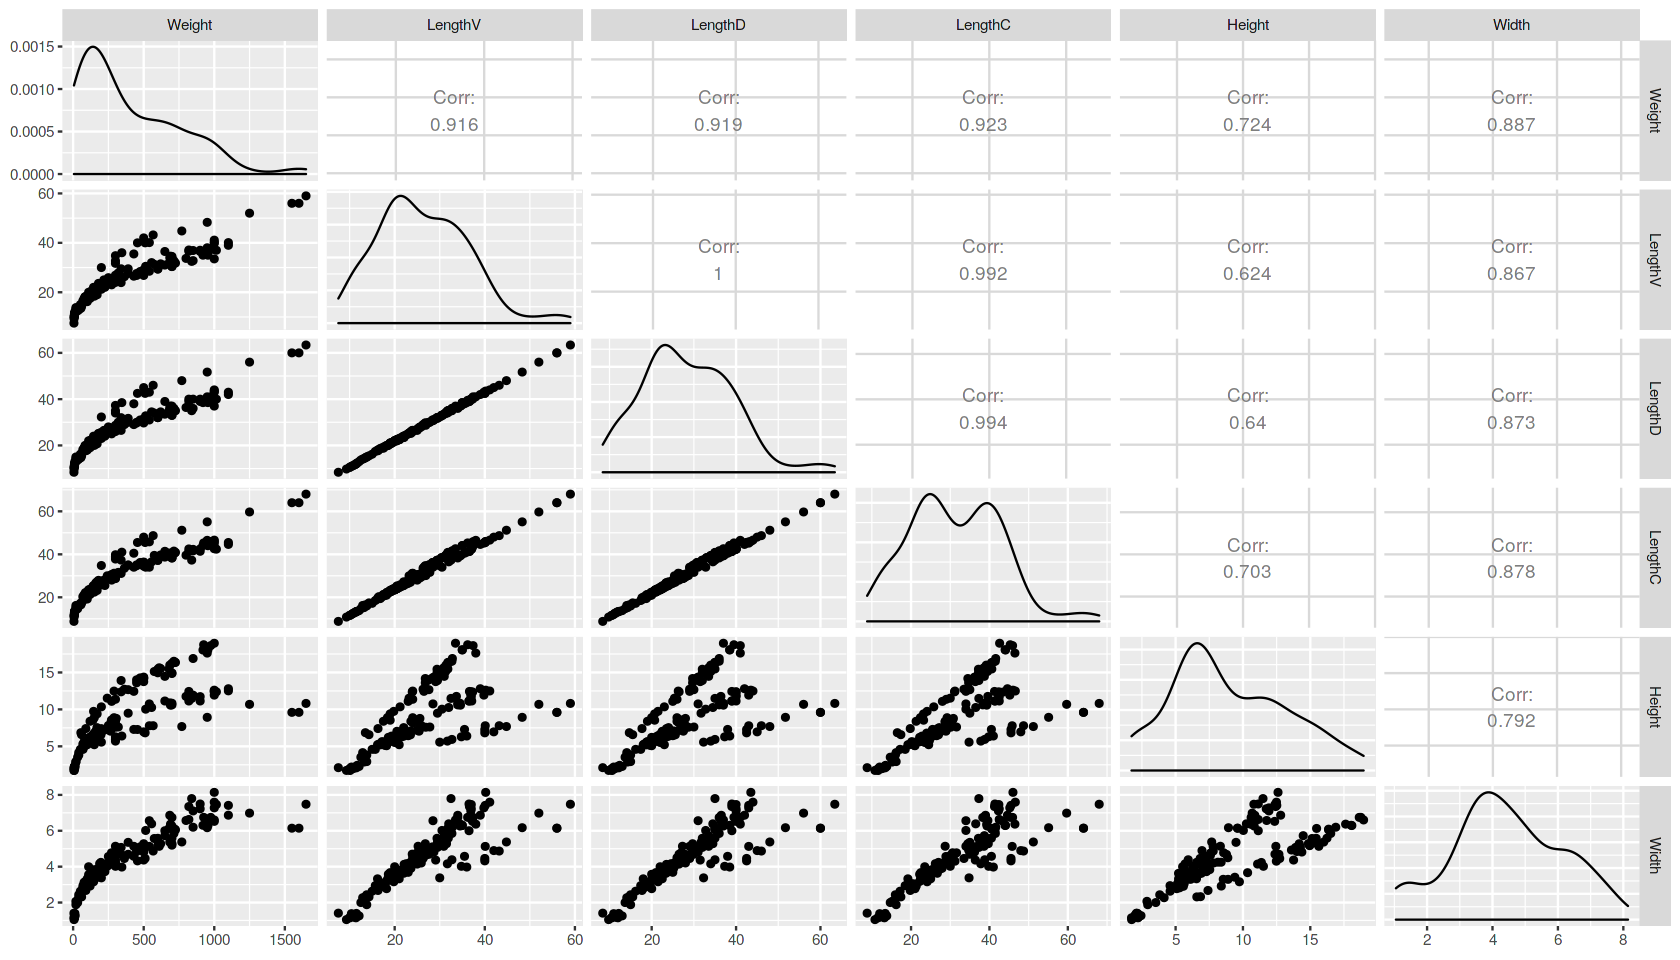

In [11]:
ggpairs(fish[2:7])

This **multivariate plot** gives us two notable informations that we need to deepen before modelling:

1. *The relationship between **Weight** and the other variables **isn't linear***
The following scatterplots analize more in-depth the distribution of **Weight** compared to **LengthV**, **Height** and **Width**.

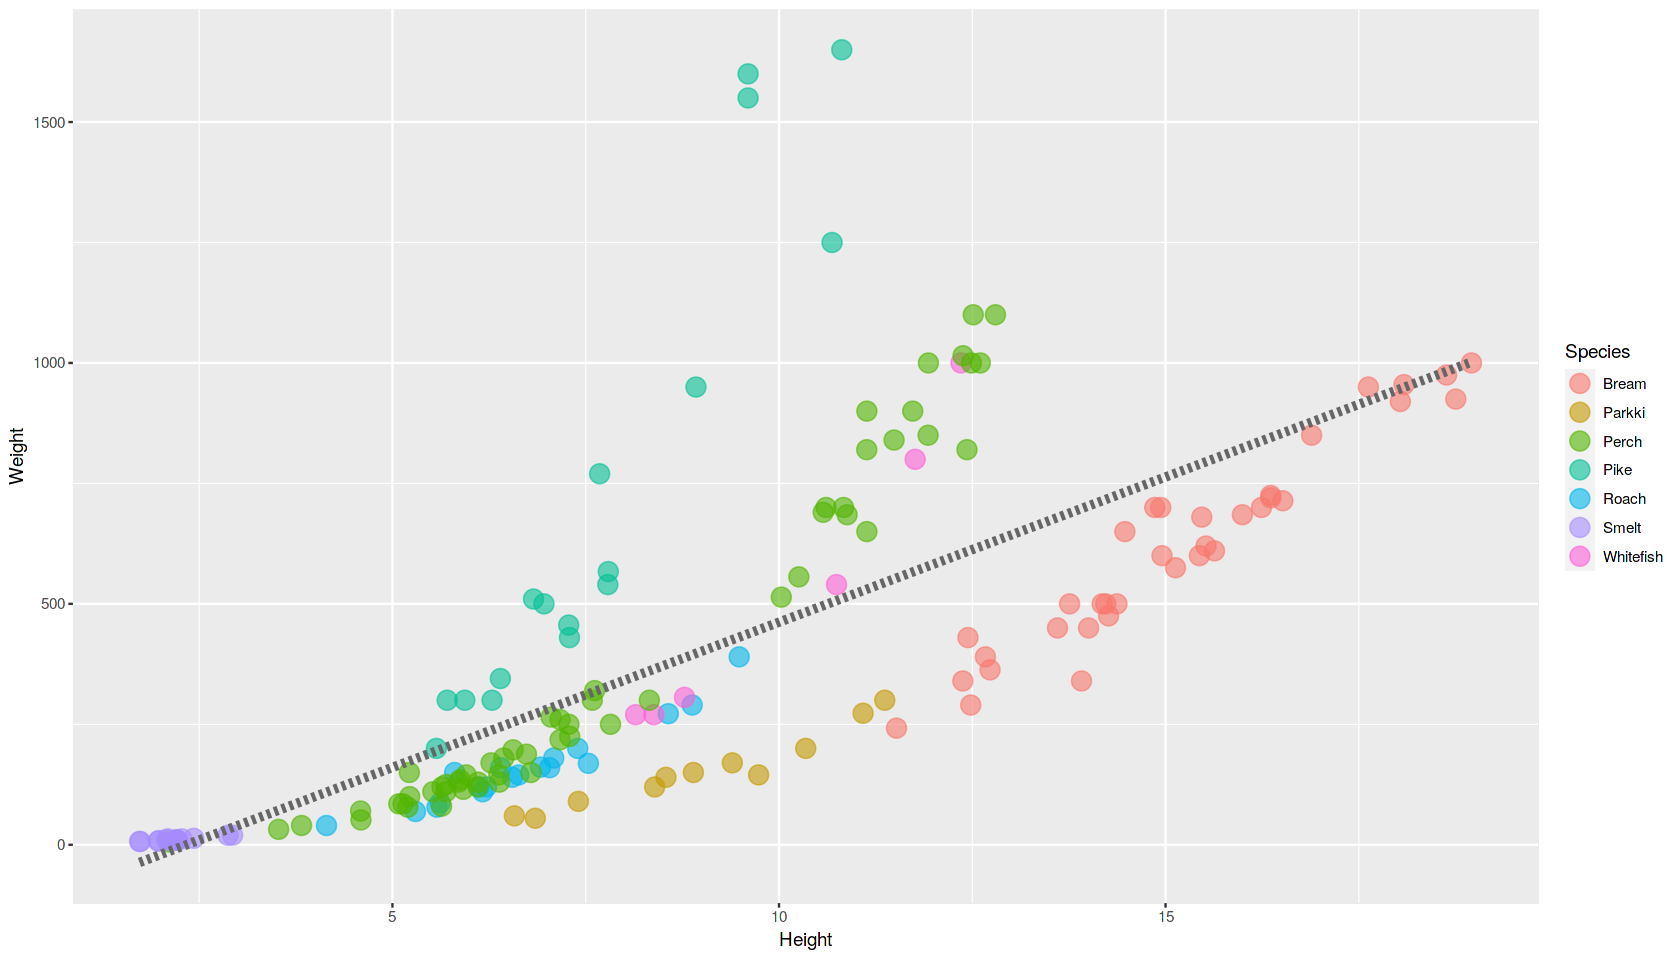

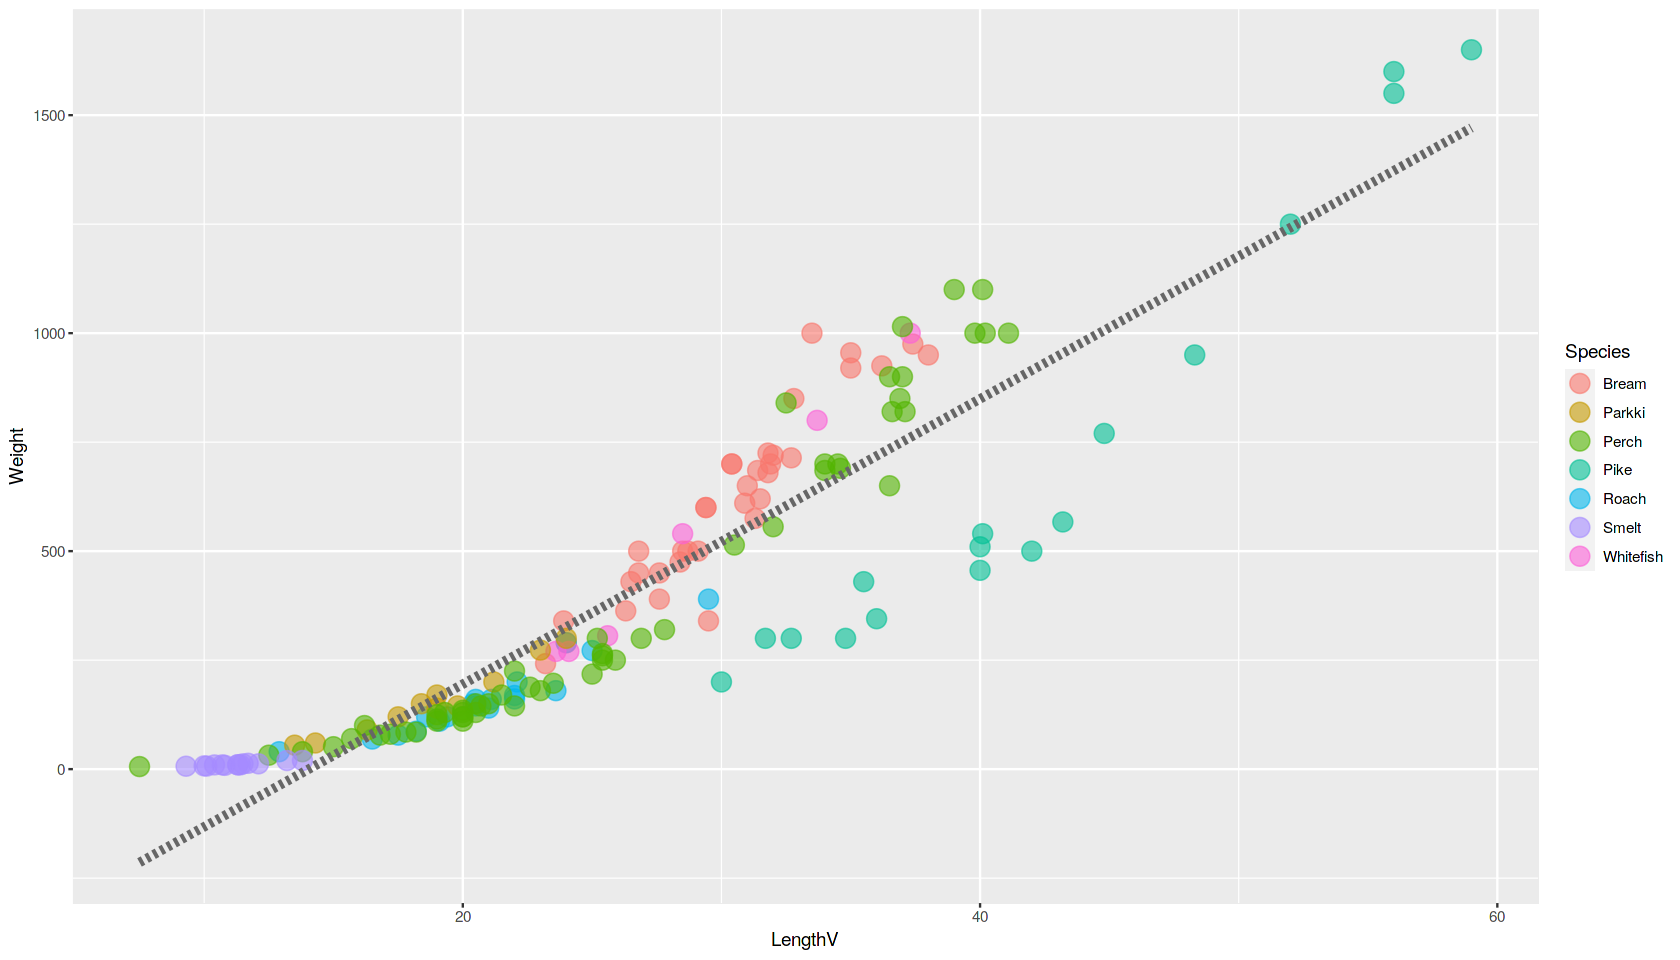

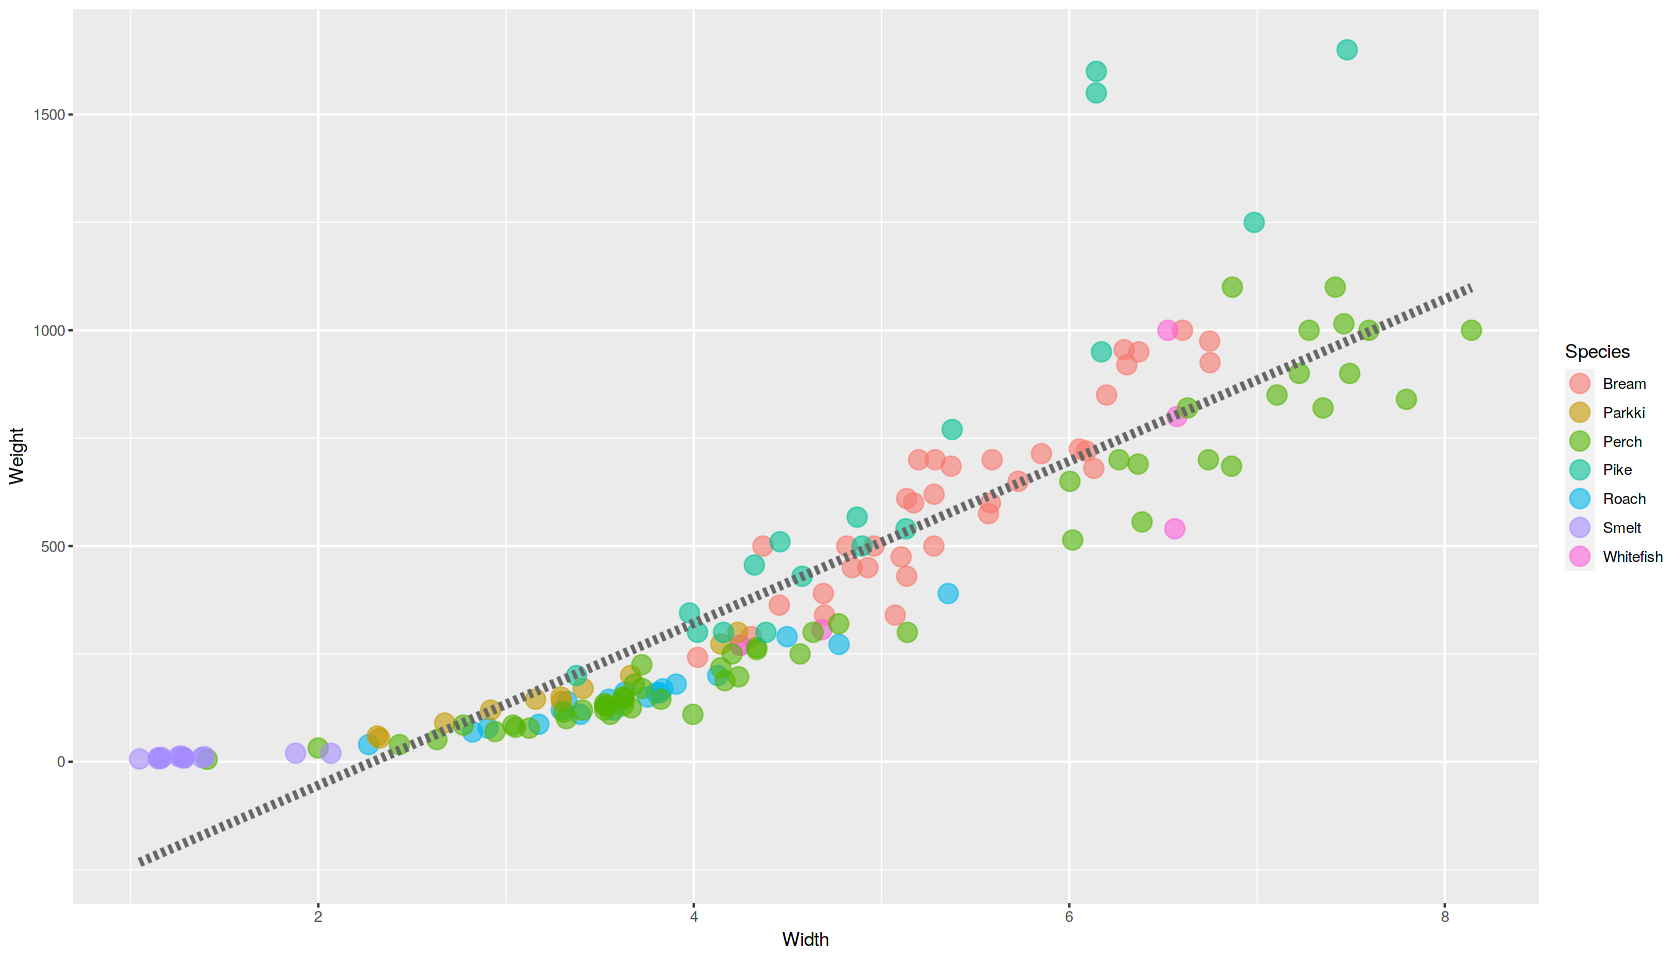

In [12]:
Height_Weight <- ggplot(fish,aes(x=Height,y=Weight,col=Species))+
                 geom_point(size=5,alpha=0.6)+
                 geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,formula="y~x")

LengthV_Weight <- ggplot(fish,aes(x=LengthV,y=Weight,col=Species))+
                  geom_point(size=5,alpha=0.6)+
                  geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,formula="y~x")

Width_Weight <- ggplot(fish,aes(x=Width,y=Weight,col=Species))+
                 geom_point(size=5,alpha=0.6)+
                 geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,formula="y~x")

Height_Weight
LengthV_Weight
Width_Weight


**These relationships aren't linear**. So, fitting a straight line through the data doesn't give us the best results. A linear model doesn't capture the **non-linearity** of the relationships between our dependend variable and the other features that we are going to use in our regression models. 

We have two ways to fix this issue:

 - Find a more complex model that can explain what a simple straight line cannot;
 - Transform our data to linearize the relationship between **Weight** and the other variables;
 
The second option is really simple and works well for our necessities.
By applying a logarithmic transformation to **Weight**,**LenghtV**,**Height** and **Width** the problem is solved!


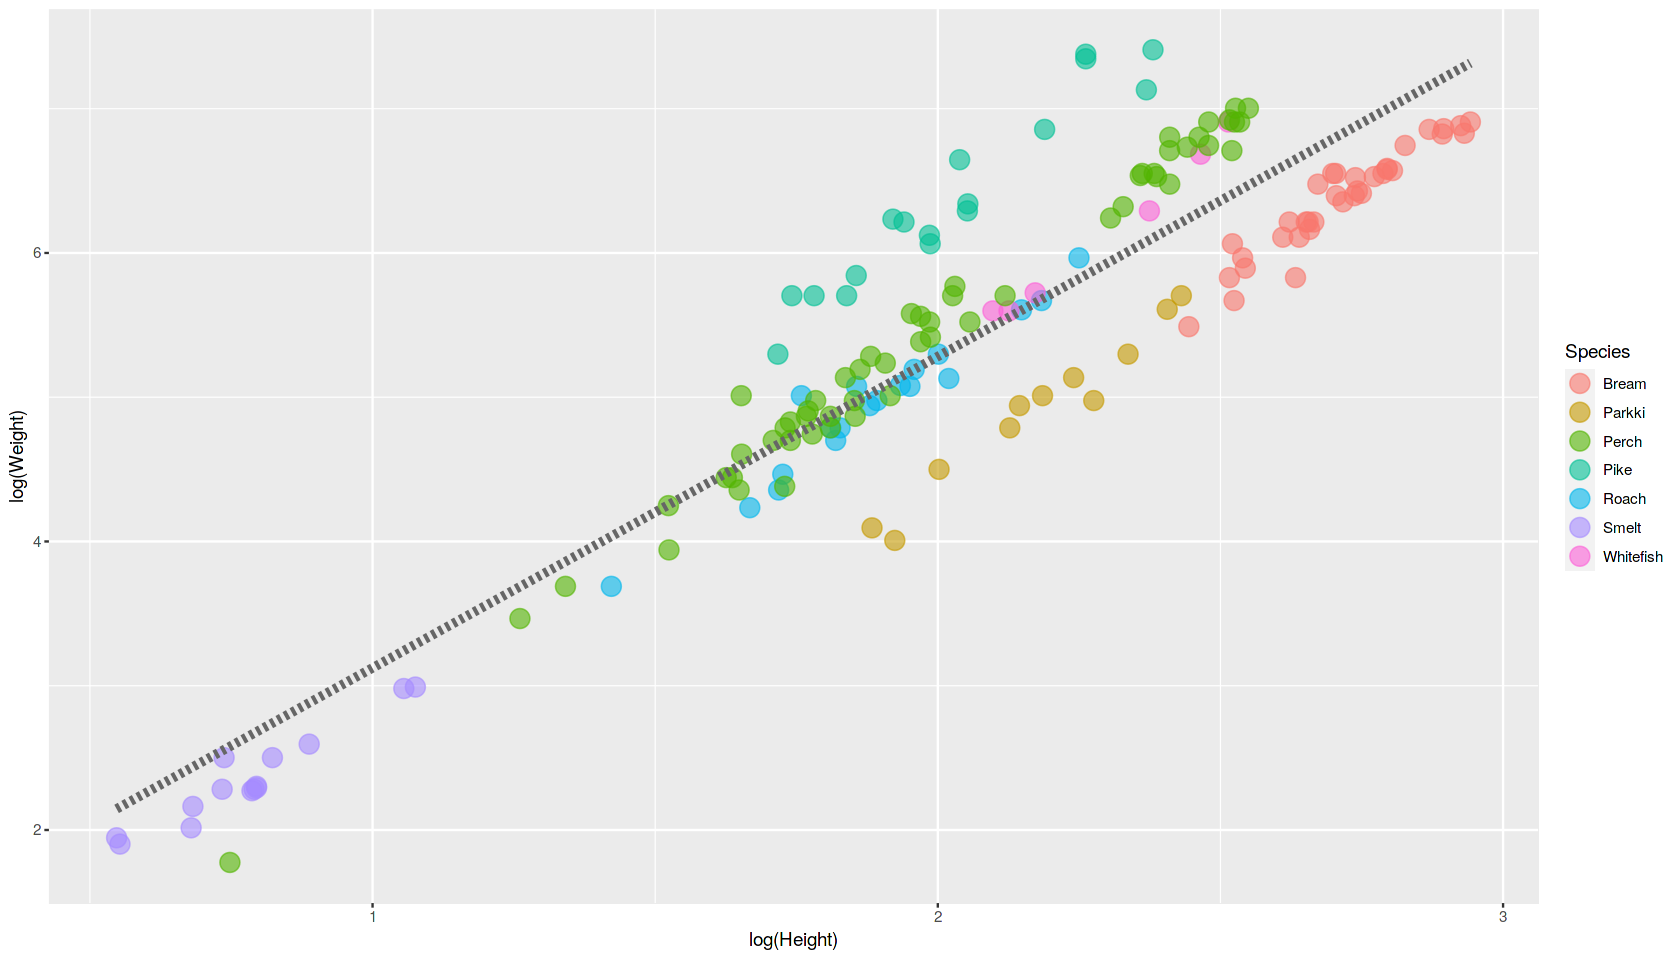

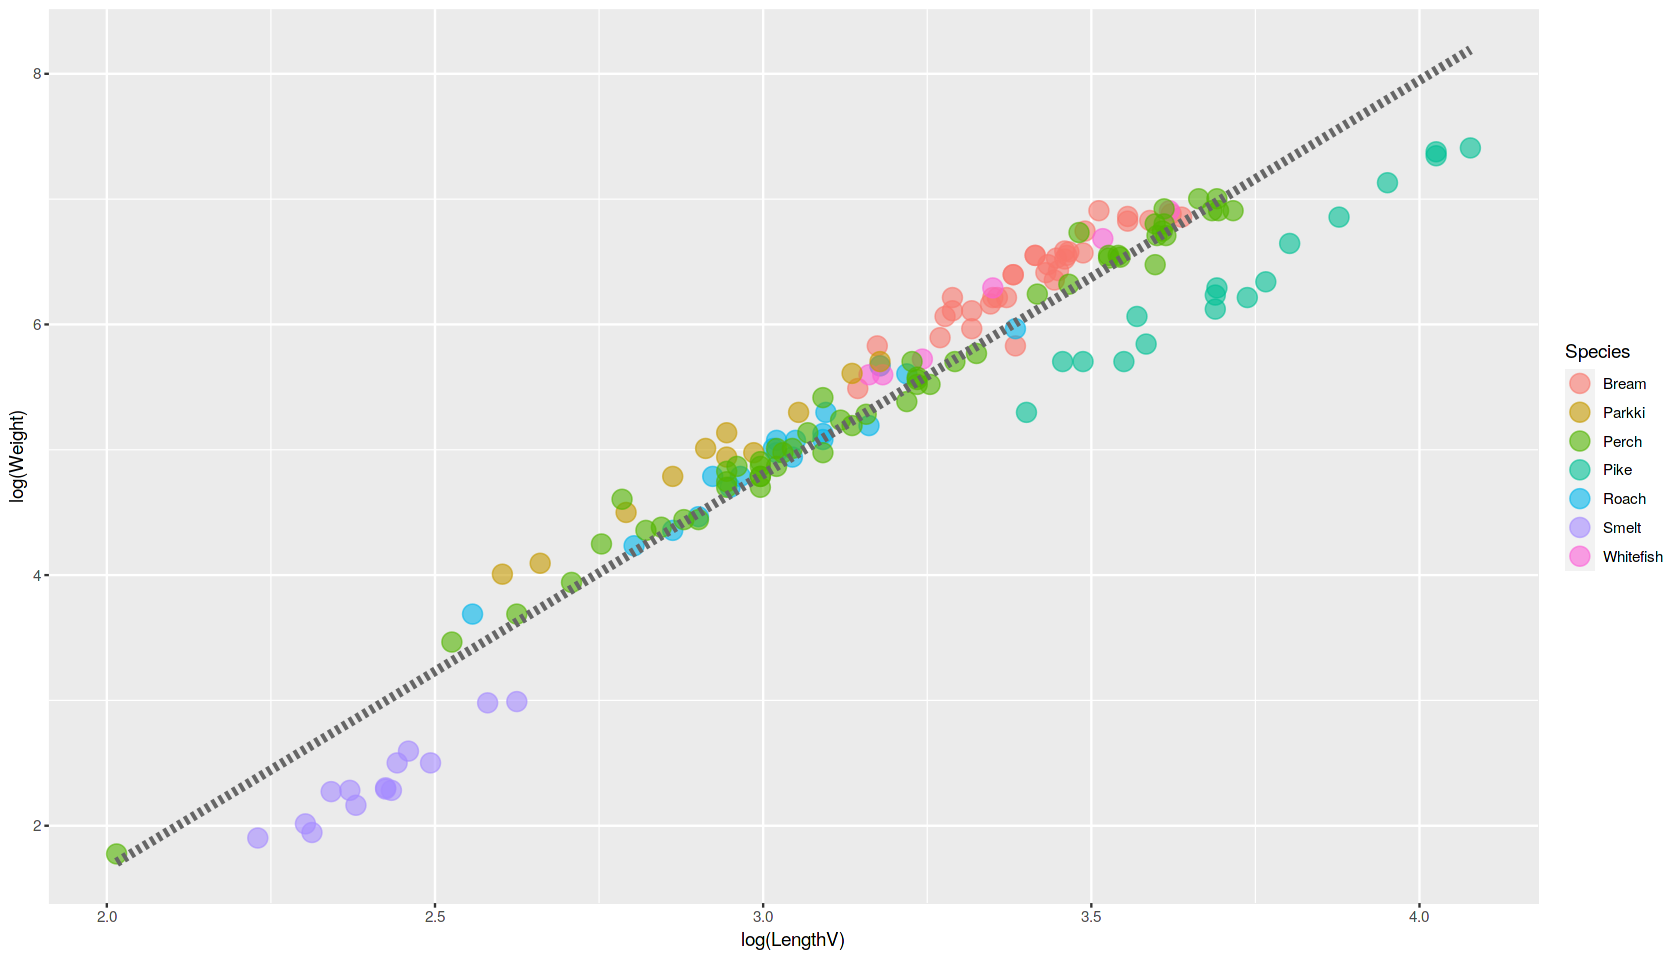

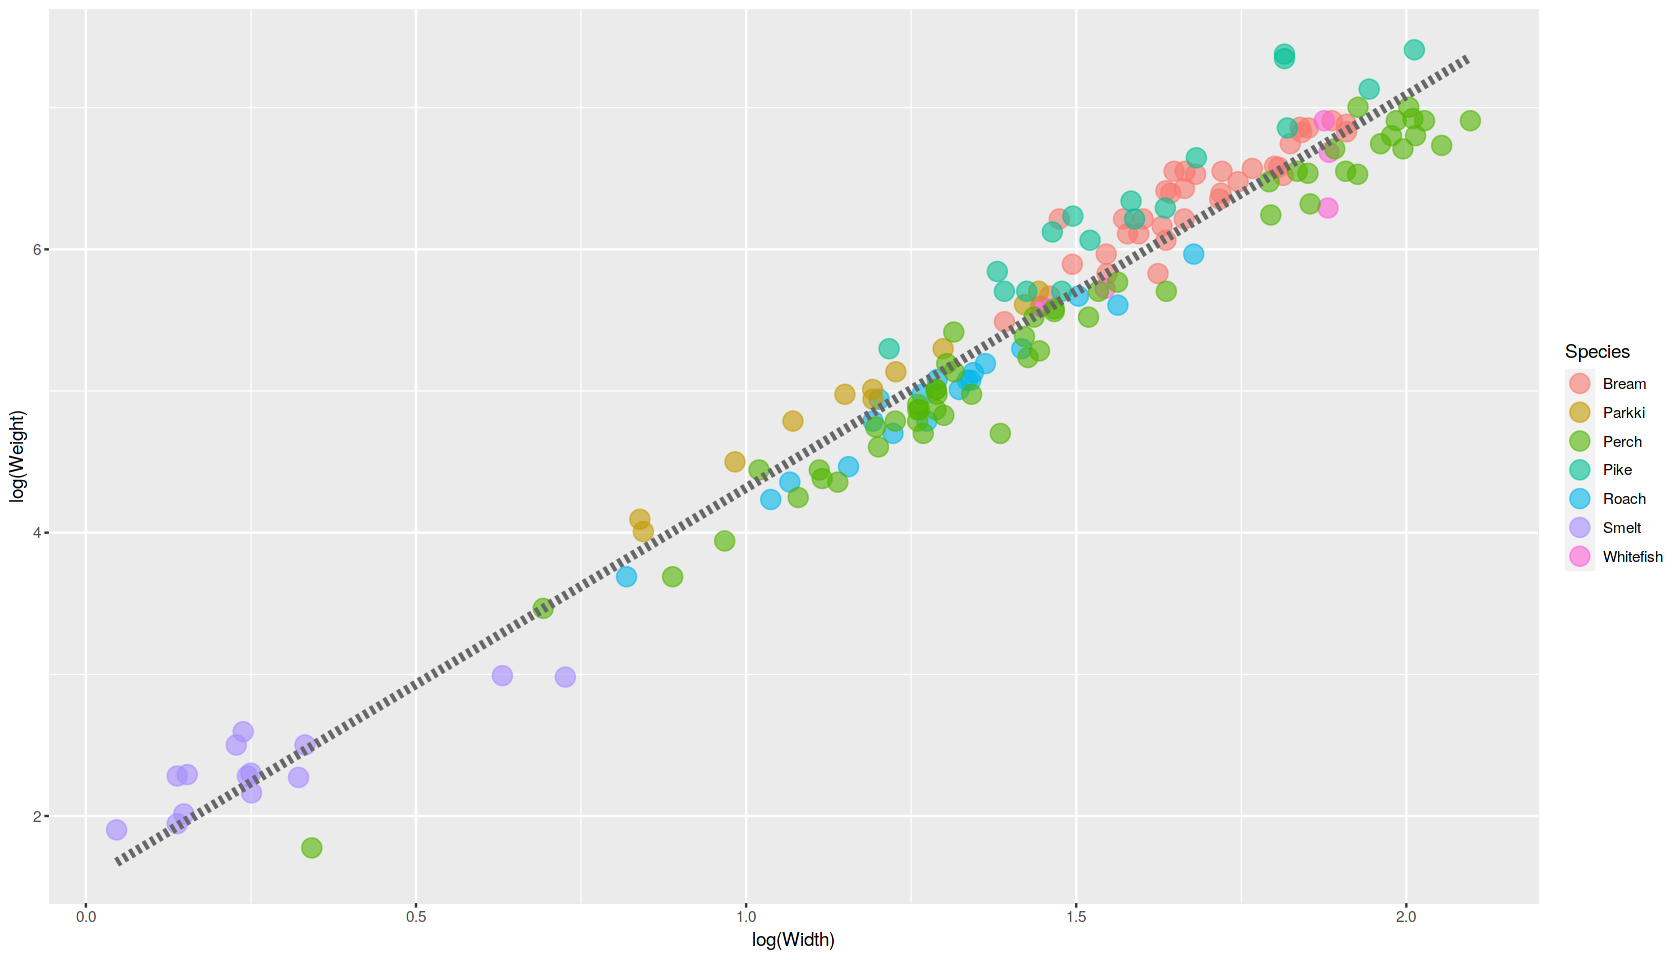

In [13]:
Height_Weight_log <- ggplot(fish,aes(x=log(Height),y=log(Weight),col=Species))+
                 geom_point(size=5,alpha=0.6)+
                 geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,,formula="y~x")

LengthV_Weight_log <- ggplot(fish,aes(x=log(LengthV),y=log(Weight),col=Species))+
                  geom_point(size=5,alpha=0.6)+
                  geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,,formula="y~x")

Width_Weight_log  <- ggplot(fish,aes(x=log(Width),y=log(Weight),col=Species))+
                 geom_point(size=5,alpha=0.6)+
                 geom_smooth(col="grey40",method = "lm",se=F,lty="dashed",lwd=2,,formula="y~x")

Height_Weight_log
LengthV_Weight_log
Width_Weight_log




A straight line now perfectly fits our data, and the differences between the various **Species** are less markable.


2. The correlation between **LengthV**, **LengthD** and **LengthC** is almost equal to **1**

With the *cor()* function, we obtain a [variance-covariance matrix](https://datascienceplus.com/understanding-the-covariance-matrix/) for our **indipendent variables**.


In [14]:
fish_x <- fish%>%
          select(LengthV,LengthD,LengthC,Height,Width)

cor(fish_x)  

,LengthV,LengthD,LengthC,Height,Width
LengthV,1.0000000,0.9995162,0.9920042,0.6244087,0.8666843
LengthD,0.9995162,1.0000000,0.9940830,0.6395032,0.8732011
LengthC,0.9920042,0.9940830,1.0000000,0.7026548,0.8781887
Height,0.6244087,0.6395032,0.7026548,1.0000000,0.7924005
Width,0.8666843,0.8732011,0.8781887,0.7924005,1.0000000


The correlation values between **LengthV**, **LengthD** and **LengthC** are **0.9995**,**0.9920** and **0.9941**. 

Having two or more variables which are almost a **linear combination** of each other can cause some serious issues to our regression model. This problem is called **Multicollinearity**(learn more about collinearity [here](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)). The fact that these three variables are Multicollinear means that we have redundant informations.

We will discuss more deeply about this problem later.

We have plotted and analyzed our data enough. Now let's start modelling!


# 5. Multiple Linear Regression

The first model that we're going to use is **Multiple Linear Regression**. Our dependent variable is **Weight**, and our indipendent variables are **LengthV**,**LengthD**,**LengthC**,**Height** and **Width**. I didn't use the **Species** coloumn to not over-complicate the model. **Species** is a factor variable with **7 different levels**. Using this variable means creating 7 dummy variables, and have 7 different straight lines,each one with a unique intecept. 
Too complicated! **KISS** . 

The following function creates the multiple linear model that we need:

In [15]:
fish.reg <- lm(Weight ~ LengthV + LengthD + LengthC + Height + Width,data = fish)
summary(fish.reg)


Call:
lm(formula = Weight ~ LengthV + LengthD + LengthC + Height + 
    Width, data = fish)

Residuals:
    Min      1Q  Median      3Q     Max 
-243.96  -63.57  -25.82   57.90  448.69 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -496.802     29.616 -16.775  < 2e-16 ***
LengthV       63.969     40.169   1.592  0.11335    
LengthD       -9.109     41.749  -0.218  0.82759    
LengthC      -28.119     17.343  -1.621  0.10701    
Height        27.926      8.721   3.202  0.00166 ** 
Width         23.412     20.355   1.150  0.25188    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 123 on 152 degrees of freedom
Multiple R-squared:  0.8855,	Adjusted R-squared:  0.8817 
F-statistic: 235.1 on 5 and 152 DF,  p-value: < 2.2e-16


The **p-value** of the variables **LengthV**,**LengthC** and **LengthD** is quite high, suggesting us that these variables are not significant. These p-values are caused by the high correlation between the three types of Length. We can solve **collinearity** in three ways:

- Increasing the number of observation (**n**)
- Introducing new variables
- Removing the collinear variables

The third approch is the best in our case. We can't add new observations, and by removing redundant variables we don't lose too much informations. So, we can remove **LengthD** and **LengthC**, and just consider **LengthV**


In [16]:
fish.reg.red <- lm(Weight ~ LengthV + Height + Width,data = fish)
summary(fish.reg.red)


Call:
lm(formula = Weight ~ LengthV + Height + Width, data = fish)

Residuals:
    Min      1Q  Median      3Q     Max 
-249.24  -73.13  -27.96   75.11  443.17 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -511.471     28.593 -17.888  < 2e-16 ***
LengthV       22.605      2.019  11.198  < 2e-16 ***
Height        13.590      3.848   3.532 0.000545 ***
Width         44.266     15.321   2.889 0.004420 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 123.6 on 154 degrees of freedom
Multiple R-squared:  0.8828,	Adjusted R-squared:  0.8805 
F-statistic: 386.7 on 3 and 154 DF,  p-value: < 2.2e-16



Using only **LengthV**,**Height** and **Width**, all the p-values decreased, and the variance of the parameter associated with **LengthV** is now acceptable. 

Obviusly the **R2** decreased, but that's not a problem. 
(*Don't use the R2 statistic to compare two model with different number of indipendent variable!*)

To understand which model performs better on our data, we use three useful tools:  **F-test**,**AIC** and **BIC**

In [17]:
cat("F-TEST:")
anova(fish.reg.red,fish.reg)

cat("AIC:")
AIC(fish.reg.red,fish.reg)

cat("BIC:")
BIC(fish.reg.red,fish.reg)




F-TEST:

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,154,2354289,NA,NA,NA,NA
2,152,2300423,2,53865.4,1.779573,0.1722071


AIC:

,df,AIC
,<dbl>,<dbl>
fish.reg.red,5,1976.631
fish.reg,7,1976.974


BIC:

,df,BIC
,<dbl>,<dbl>
fish.reg.red,5,1991.944
fish.reg,7,1998.412



The *anova()* function performs for us a F-test. The resultant **p-value** is higher than **0.10**, so we don't refuse the null Hypotesis. Also, the **AIC** and **BIC** have smaller values with the *fish.reg.red* model. In simple terms, using the two "extra" variables **LengthC** and **LengthD** didn't increase enough our knowledge about the dependent variable (**Weight**), and so it's better to use a simpler model (*fish.reg.red*). 

Let's take a look at the distribution of residuals:

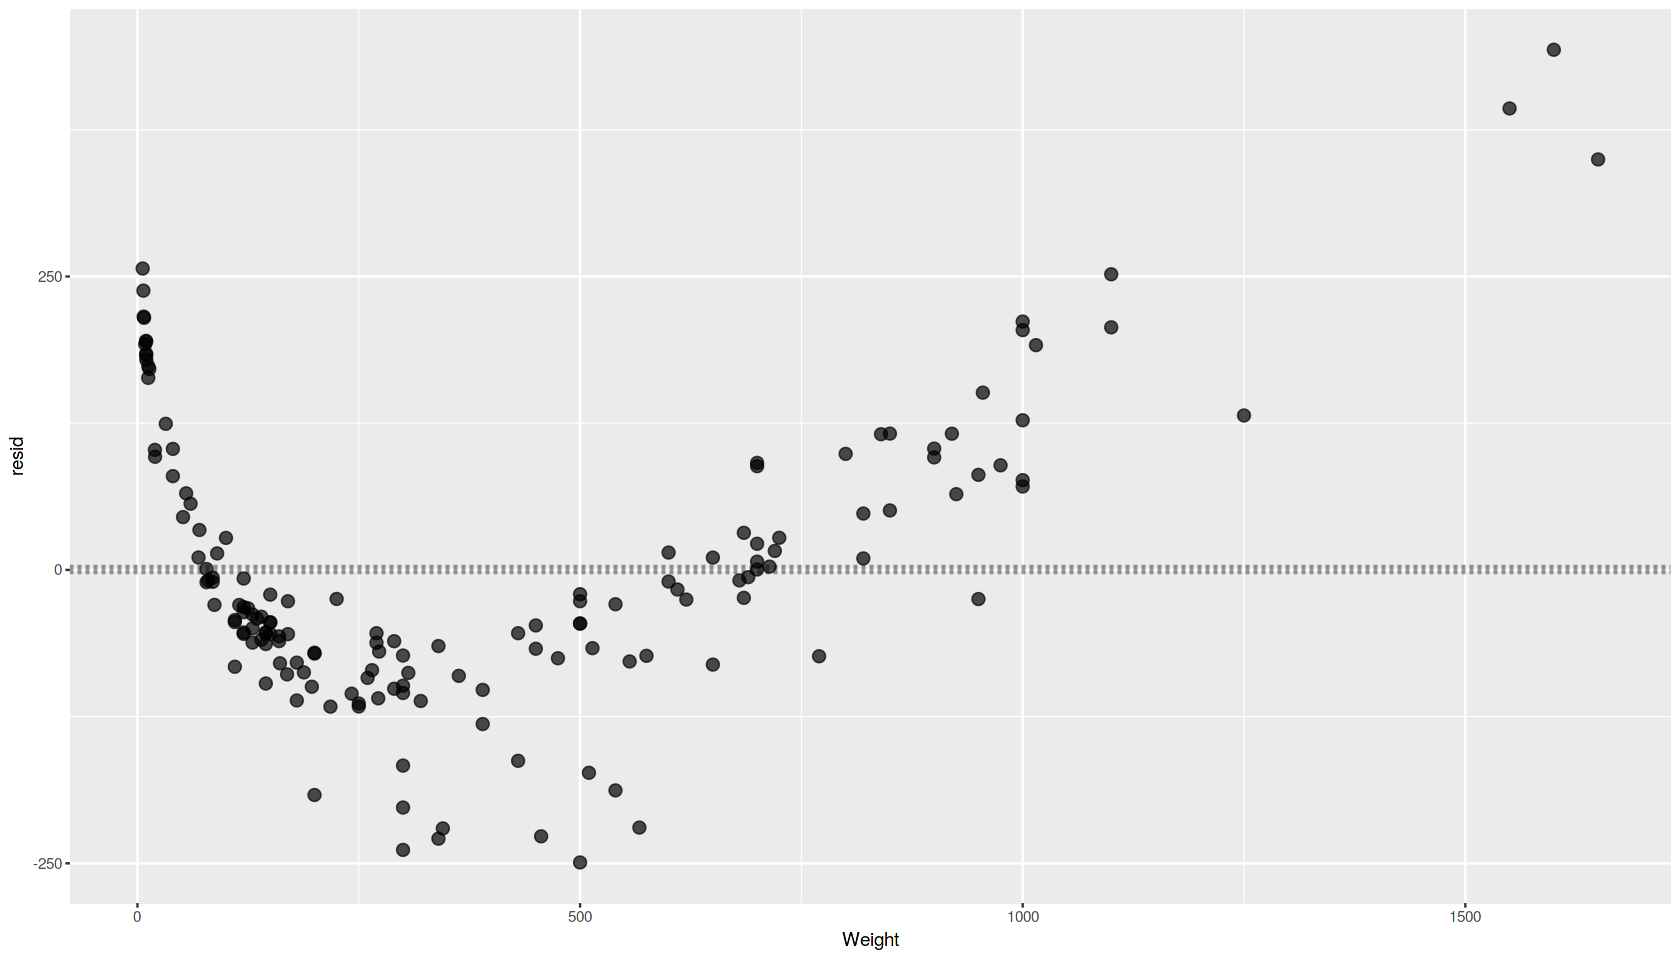

In [18]:
residplot.lin <- data.frame(resid=fish.reg.red$residuals,Weight=fish$Weight)


ggplot(residplot.lin,aes(x=Weight,y=resid))+
  geom_hline(yintercept = 0,size=2,lty="dashed",alpha=0.4)+
  geom_point(size=3,alpha=0.7)


That's not how residuals should look like! As you can see, the residuals follow a **visible pattern**. 
If a model really explains the relationship between the dependent variable and the indipendent variables this should not happen!

The model *fish.reg.red* has an high **R2**,and all of the parameters are significant, but it certainly fails in capturing the real relationship between the **Y** and the **Xs**.

Luckly, we already now that applying a loghritimic transformation to our data the relationship becomes linear.

So let's transform our data and fit a new model


In [19]:
fish.reg.ll <- lm(log(Weight) ~ log(LengthV) + log(Height) + log(Width),data=fish)
summary(fish.reg.ll)


Call:
lm(formula = log(Weight) ~ log(LengthV) + log(Height) + log(Width), 
    data = fish)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43356 -0.05497 -0.00080  0.05029  0.27291 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.77300    0.11484  -15.44   <2e-16 ***
log(LengthV)  1.42951    0.05157   27.72   <2e-16 ***
log(Height)   0.62930    0.03293   19.11   <2e-16 ***
log(Width)    0.94874    0.06185   15.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09895 on 154 degrees of freedom
Multiple R-squared:  0.9945,	Adjusted R-squared:  0.9944 
F-statistic:  9349 on 3 and 154 DF,  p-value: < 2.2e-16


This type of model is called **Log-Log linear regression** (learn more about it [here](https://www.dummies.com/education/economics/econometrics/econometrics-and-the-log-log-model/))

All the variables are very statistically significant and the **R2** is really high!. But we can't use the **R2**, or tools like the **AIC** and the **BIC** to compare the **Log-Log model** with the *fish.red.reg* model because the dependent variable is not the same (**y** is not equal to **log(y)**)

But since our final objective is prediction, we can try to predict the Weight with both models and then check wich model does it better.

Let's check if the logharitmic tranformation fixed our problems with the distribution of residuals:

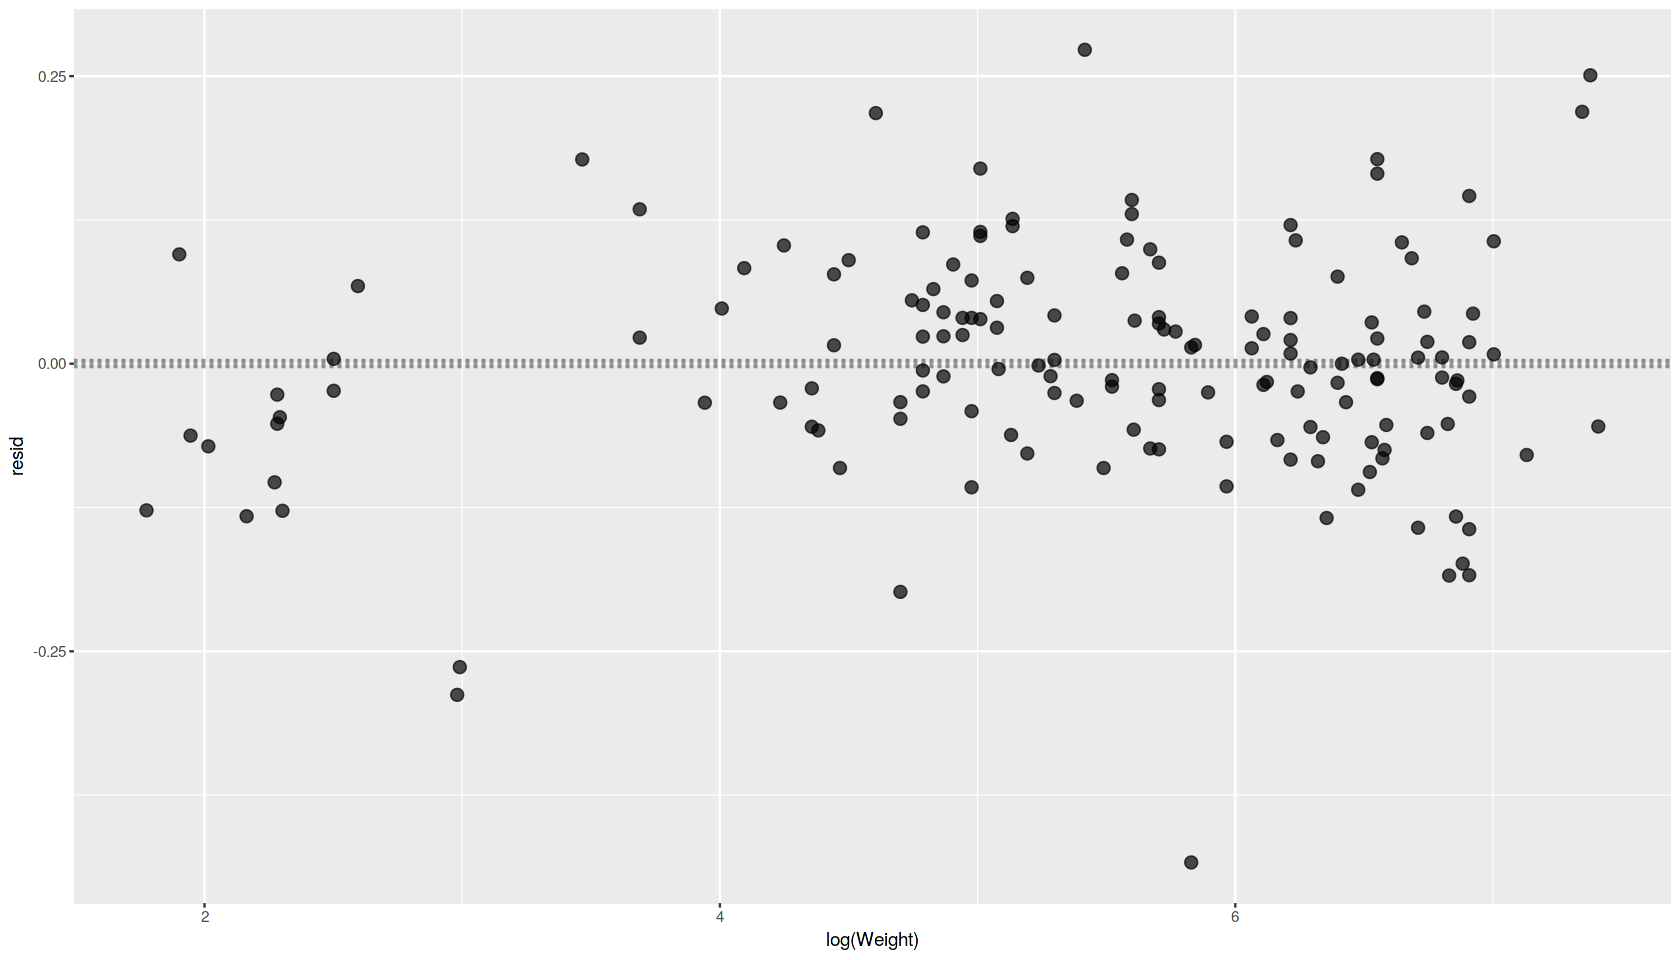

In [20]:
residplot.ll <- data.frame(resid=fish.reg.ll$residuals,Weight=fish$Weight)

ggplot(residplot.ll,aes(x=log(Weight),y=resid))+
  geom_hline(yintercept = 0,size=2,lty="dashed",alpha=0.4)+
  geom_point(size=3,alpha=0.7)

Great! 
Now the residuals don't follow a scheme, and so we are sure that the **Log-Log** model captures the real relationship between **Weight** and **LengthV**,**Height** and **Width**.

Just to be sure, we can use a **Breusch & Pagan Test** to check if the residuals are **heteroskedastical**


In [21]:
bptest(fish.reg.ll)


	studentized Breusch-Pagan test

data:  fish.reg.ll
BP = 0.462, df = 3, p-value = 0.9272



The **Null Hypothesis** is not rejected (it means that the residuals are **homoskedastical**), so we don't need to fix heteroskedasticity issues.


# 6. Prediction

Let's now use all the things that we have learned to predict the **Weight** of a fish. We're going to make predictions with two models, *fish.reg.red* and *fish.reg.ll*, and check which model does the better job.

With the following script, we split our data in **Train** set and **Test** set...

In [22]:
fish$train <- sample.split(fish$Weight,SplitRatio = 0.7)
fish.train <- fish[fish$train==TRUE,]
fish.test <- fish[fish$train==FALSE,]

And fit our **two models** only using the observations that are in the **training set**.


In [23]:
fish.reg.red<- lm(Weight ~ LengthV + Height + Width,data = fish.train)
fish.reg.ll <- lm(log(Weight) ~ log(LengthV) + log(Height) + log(Width),data=fish.train)


Using our two fitted multiple linear regression model, we can finally make predictions on the observations that are in the **test set**.



In [24]:
pred.lin <- predict(fish.reg.red,fish.test)
cat("R2 of the Non-Transformed Linear Model:",R2(pred.lin,fish.test$Weight))

pred.ll <- exp(predict(fish.reg.ll,fish.test))
cat("\nR2 of the Log-Log Linear Model:",R2(pred.ll,fish.test$Weight))

R2 of the Non-Transformed Linear Model: 0.8987399
R2 of the Log-Log Linear Model: 0.9689068

The **R2** of the prediction of the **Log-Log multiple linear regression** is much higher then the one obtained with the **non-trasformed multiple regression model**. 

The **Log-Log model** is better at predicting than the *fish.reg.red* model!

Let's use a scatterplot to visualize the real values of **Weight**, and the predictions made by our two different model

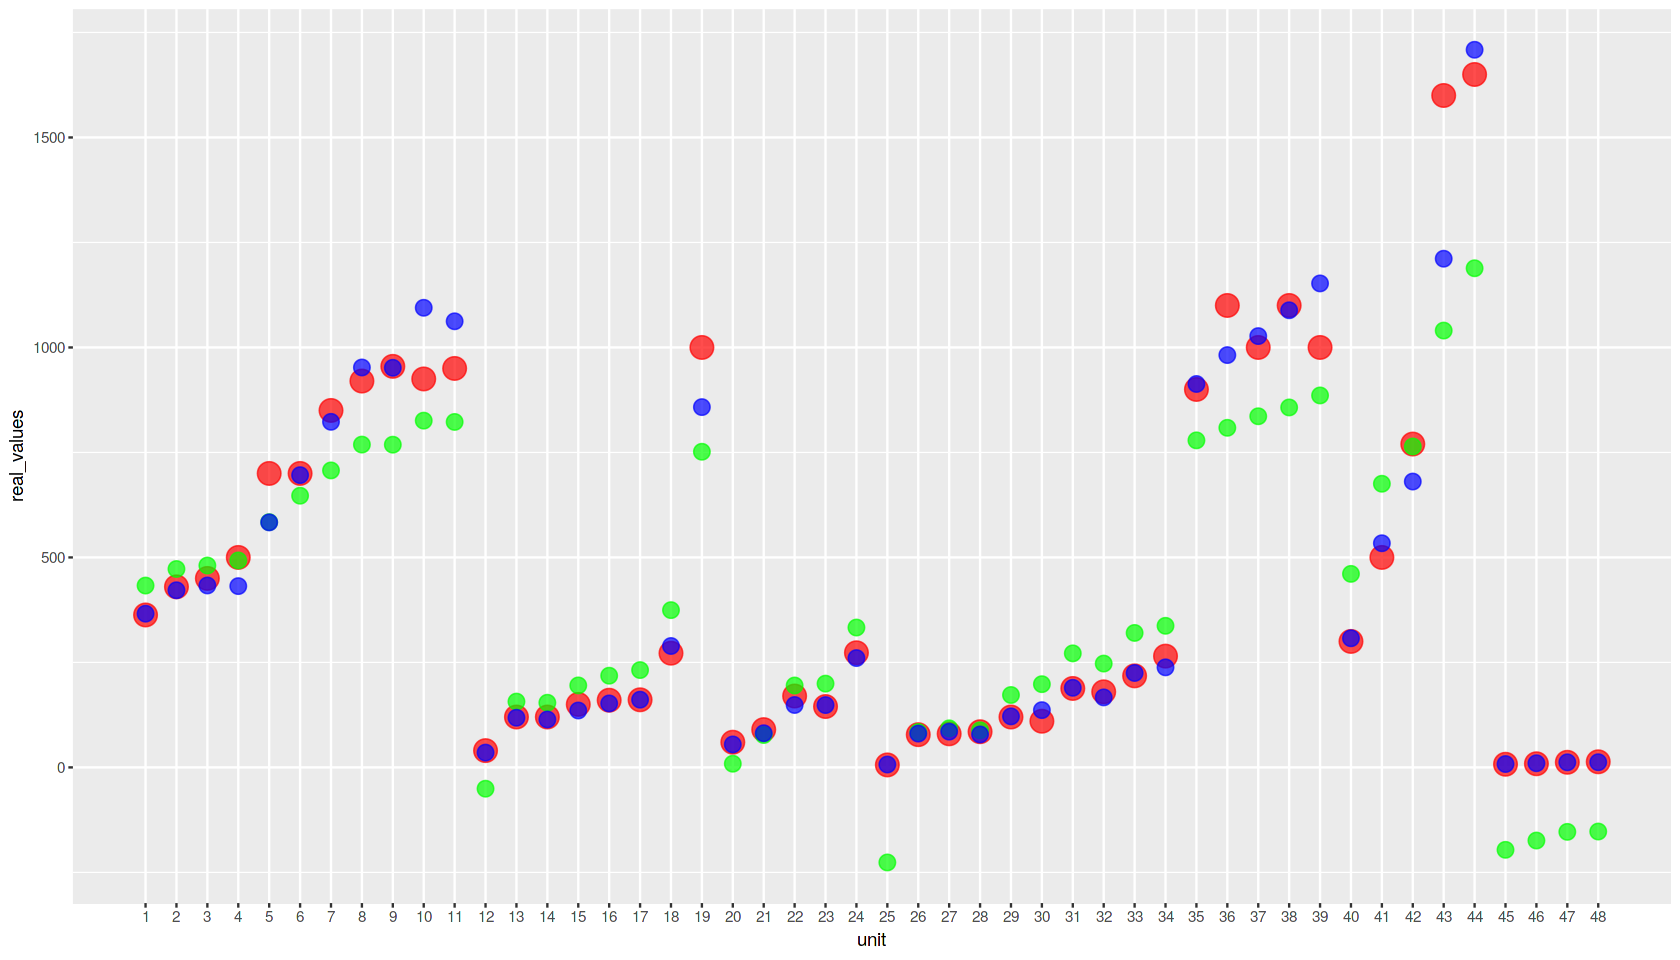

In [25]:
pred_plot <- data.frame(pred_ll=pred.ll,pred_lin=pred.lin,real_values=fish.test$Weight,unit = seq(1,length(fish.test$Weight),by=1))

ggplot(pred_plot,aes(x=unit,y=real_values))+
  geom_point(col="red",size=6,alpha=0.7)+
  geom_point(aes(x=unit,y=pred_lin),col="green",size=4,alpha=0.7)+
  geom_point(aes(x=unit,y=pred_ll),col="blue",size=4,alpha=0.7)+
  scale_x_continuous(breaks=seq(1,48,by=1),labels  =seq(1,48,by=1),minor_breaks = NULL)



The predictions made with the **Log-Log model** (blue dots) are clearly closer to the **real values** (red dots) then the predictions made with the **non-transformed linear model** (green dots).

It's also important to underline an useful propriety of the Log-Log model : **all the predictions made by this model are Positive**. 
Why? Because we used the exponential function to bring the fitted values back to the same unit of measurement of the real values. In our case this constraint is a great advantage, because obviously the weight of a fish cannot be negative.

On the other side, a **non-transformed multiple linear model** can also assume negative fitted values, which is a big issue if we want only positive predictions.

In [26]:
pred_plot[pred_plot$pred_lin<0,c(1,2,3)]

,pred_ll,pred_lin,real_values
,<dbl>,<dbl>,<dbl>
36,35.275720,-50.71308,40.0
72,6.871887,-226.30468,5.9
146,8.026258,-196.25671,7.5
150,9.925120,-174.12655,8.7
154,12.147385,-153.47155,12.2
155,12.366732,-152.68372,13.4


# 7. Conclusion

In this study we predicted the **Weight** of a fish using two multiple linear model. We can conlude that the **Log-Log linear model** is by far the best regression model to predict the **Weight**, but if you really want to keep it simple, using a **Non-transformed linear regression** is a good choice too.

If you have read this far, I sincerely want to thank you for your attention and patience. This is my first notebook here on Kaggle, so if you find any type of error, or you just want to some more info or even if you have a different type of solution that you want to discuss, I invite you to leave a comment or to send me an e-mail.

### If this notebook helped you in any way or you liked it, please upvote and/or leave a comment!